<a href="https://colab.research.google.com/github/jacmal/ML_Image-Plant-Disease-CNN-Multiclass_Classyfication/blob/main/CNN_Plant_Pathology_unbalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd

import random
import shutil
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

#from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
pd.options.mode.chained_assignment = None

# Data Preprocessing

In [3]:
# dataset folder path
folders_path = '/content/drive/MyDrive/Datasets/Plant Pathology 2020 - FGVC7/images'

In [4]:
# list of all files in dataset folder
f_list = os.listdir(folders_path)
print(f_list[:5])

['Train_1729.jpg', 'Train_1761.jpg', 'Train_1715.jpg', 'Train_1740.jpg', 'Train_1720.jpg']


In [5]:
# list of all image files
all_images = list(filter(lambda f: True if f[-4:] == '.jpg' and f[:5] == 'Train' else False, f_list))
print('All images: ', len(all_images))

All images:  1821


In [6]:
# load .csv file with image labels into DataFrame
df = pd.read_csv('/content/drive/MyDrive/Datasets/Plant Pathology 2020 - FGVC7/train.csv')
df.head(3)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0


In [7]:
# list of all image classes
col_list = list(df.columns)[1:]
print(col_list)

['healthy', 'multiple_diseases', 'rust', 'scab']


In [8]:
# create numerical and text labels
text_l = []
num_l = []

for i in range(len(df)):
  for col_name in col_list:
    if df[col_name].loc[i] == 1:
      text_l.append(col_name)
      num_l.append(col_list.index(col_name))

df_labels = pd.DataFrame({'image_id': df['image_id'], 'text_label': text_l, 'num_label': num_l})
df_labels

,image_id,text_label,num_label
0,Train_0,scab,3
1,Train_1,multiple_diseases,1
2,Train_2,healthy,0
3,Train_3,rust,2
4,Train_4,healthy,0
...,...,...,...
1816,Train_1816,scab,3
1817,Train_1817,healthy,0
1818,Train_1818,healthy,0
1819,Train_1819,rust,2


## Data set analysis

In [9]:
# disply dataset classes histogram
px.histogram(data_frame=df_labels, 
             x='text_label',
             title='Plant pathology data set class histogram', 
             template='plotly_dark')

In [10]:
# count images of all classes
print(df_labels['text_label'].value_counts())

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: text_label, dtype: int64


## Creation of a new data set with photos sorted into separate class folders.

In [11]:
# add ".jpg" into file names in DataFrame
df_labels['image_id'] = df_labels['image_id'].apply(lambda f_name: f_name+'.jpg')

In [12]:
def sort_rename_images(folder_path: str, file_name_list: list, labels_list: list):
  '''
  Create class folders for image separtion.
  Sorts pictures into separate class folders and return a list of new file names.
  
  Args:
        folder_path (str): Path to folder with images.
        file_name_list (list): List with filenames.
        labels_list (list): List with image labels.

  Returns:
        list: Return a list of new file names.
  '''
  
  # create new folders for image classes
  class_names = set(labels_list)
  for cls in class_names:
    new_folder_path = os.path.join(folder_path, cls)
    os.mkdir(new_folder_path)
  
  # create new file names
  new_file_names = []
  for i in range(len(file_name_list)):
    file_name = file_name_list[i]
    label = labels_list[i]
    old_file_path = os.path.join(folder_path, file_name)
    new_folder_path = os.path.join(folder_path, label)
    new_file_name = str(i) + '_' + label + '.jpg'
    
    # add new name to the list
    new_file_names.append(new_file_name)
    
    # new file path
    new_file_path = os.path.join(new_folder_path, new_file_name)
    #print(new_file_path)
    
    # move file into new location
    shutil.copy(old_file_path, new_file_path)
  
  return new_file_names

In [ ]:
# sort and rename images
new_f_names = sort_rename_images(folders_path, all_images, list(df_labels['text_label']))
print(new_f_names[:5])

In [ ]:
# add new files name to DataFrame
df_labels['new_names'] = new_f_names
df_labels.head(2)

In [ ]:
image_size = 150

# image augmentation: flip, zoom, rotation and resizing
img_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.RandomZoom(0.2, 0.2),
    layers.RandomRotation(factor=(-0.5, 0.5)),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
])

In [ ]:
def aug_balance_ds(folders_path: str, folders_list: list, img_size: int):
  '''
  Balances classes in the image dataset. 
  Checks which class of images has the most elements and creates new augmented images, 
  in the amount that is the difference between the most numerous image class and the current image class.
  
  Args:
        folders_path (str):   Path to folder with images.
        folders_list (list):  List with names of class folder.
        img_size (int):       Target image size.

  Returns:
        returns nothing
  '''
  
  # checking which class of photos has the most number of items 
  max_images = 0
  for folder in folders_list:
    folder_path = os.path.join(folders_path, folder)
    images_in_folder = len(os.listdir(folder_path))
    if images_in_folder > max_images:
      max_images = images_in_folder

  # checking how many photos are in each folder    
  for folder in folders_list:
    folder_path = os.path.join(folders_path, folder)
    images_in_folder = len(os.listdir(folder_path))
    
    # checking how many photos there are to produce
    if images_in_folder < max_images:
      images_to_make = max_images - images_in_folder
      file_names = os.listdir(folder_path)
      
      # creation of new images
      for i in range(images_to_make):
        # random image in folder
        random_img_name = random.sample(file_names, 1)[0]
        random_img_path = os.path.join(folder_path, random_img_name)

        # load and convert image to array
        random_image = image.load_img(random_img_path, target_size=(img_size, img_size))
        random_image = tf.keras.preprocessing.image.img_to_array(random_image)
        
        # augmentation function
        random_image_aug = img_augmentation(random_image)

        # new image name and path
        img_new_name = random_img_name[:-4] + '_aug_' + str(i) + '.jpg'
        aug_img_path = os.path.join(folder_path, img_new_name)
        #print(aug_img_path)
        
        # save image
        tf.keras.utils.save_img(
          aug_img_path, random_image_aug, data_format=None, file_format=None, scale=True
        )

In [ ]:
# new images creation
AUG_DATA_PATH = ''

folders_list = os.listdir(AUG_DATA_PATH)
aug_balance_ds(AUG_DATA_PATH, folders_list, image_size)

In [ ]:
def train_valid_test_split(folders_path: str, class_list: list, valid: float, test: float):
  '''
  Train, vadlidation and test data set split.
  Create folders structure required for tensorflow ImageDataGenerator.

  Example: data set main folder -> train/valid/test folders -> class folders
  
  Args:
        folders_path (str):   Path to folder with images.
        class_list (list):    List with names of class folder.
        valid (float):        Validation data set size.
        test (float):         Test data set size.

  Returns:
        returns nothing
  '''
  # create new folder for data set
  splited_ds_path = os.path.join(folders_path, 'splited_dataset')
  os.mkdir(splited_ds_path)
  new_folders = ['train', 'valid', 'test']

  # checking how many images there are in folder
  img_in_folders = len(os.listdir(os.path.join(folders_path, class_list[0])))
  #print(img_in_folders)
  
  # create counters for valid, test and train parts of the data set
  valid_count = int(img_in_folders * valid)
  test_count = int(img_in_folders * test)
  train_count = img_in_folders - valid_count - test_count
  
  # build folders structure
  for folder in new_folders:
    new_folder_path = os.path.join(splited_ds_path, folder)
    # create new folder
    os.mkdir(new_folder_path)
    for folder_c in class_list:
      new_c_folder_path = os.path.join(new_folder_path, folder_c)
      # create new class folder
      os.mkdir(new_c_folder_path)
  
  # files in each class folders
  for folder in class_list:
    folder_path = os.path.join(folders_path, folder)
    folder_files = os.listdir(folder_path)
    
    # validation data set creation
    for valid_img in range(valid_count):
      random_file = random.sample(folder_files, 1)[0]
      old_rand_file_path = os.path.join(folder_path, random_file)
      new_rand_file_path = os.path.join(splited_ds_path, 'valid')
      new_rand_file_path = os.path.join(new_rand_file_path, folder)
      new_rand_file_path = os.path.join(new_rand_file_path, random_file)
      #print(new_rand_file_path)
      
      # move file
      shutil.move(old_rand_file_path, new_rand_file_path)
      folder_files.remove(random_file)
    
    # test data set creation
    for test_img in range(test_count):
      random_file = random.sample(folder_files, 1)[0]
      old_rand_file_path = os.path.join(folder_path, random_file)
      new_rand_file_path = os.path.join(splited_ds_path, 'test')
      new_rand_file_path = os.path.join(new_rand_file_path, folder)
      new_rand_file_path = os.path.join(new_rand_file_path, random_file)
      #print(new_rand_file_path)
      
      # move file
      shutil.move(old_rand_file_path, new_rand_file_path)
      folder_files.remove(random_file)
    
    # train data set creation
    for train_img in folder_files:
      old_file_path = os.path.join(folder_path, train_img)
      new_file_path = os.path.join(splited_ds_path, 'train')
      new_file_path = os.path.join(new_file_path, folder)
      new_file_path = os.path.join(new_file_path, train_img)
      #print(new_file_path)
      
      # move file
      shutil.move(old_file_path, new_file_path)

In [ ]:
# split data set
DATA_SET_PATH = ''

class_list = [] 
train_valid_test_split(DATA_SET_PATH, class_list, 0.2, 0.2)

# Convolutional Neural Network Model

## SETTINGS

In [13]:
# settings for neural network
BASE_DIR = '/content/drive/MyDrive/Datasets/Plant Pathology 2020 - FGVC7/images/splited_dataset'
BATCH_SIZE = 32
IMG_SHAPE = 150
INPUT_SHAPE = (IMG_SHAPE, IMG_SHAPE, 3)
N_CLASSES = 4

## Training and validation Image Data Generator

In [14]:
# paths to training and validation data
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'valid')

In [15]:
# train data generator
image_gen_train = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=45,
                                    width_shift_range=.15,
                                    height_shift_range=.15,
                                    horizontal_flip=True,
                                    zoom_range=0.2
                                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                    batch_size=BATCH_SIZE,
                                                    directory=train_dir,
                                                    shuffle=True,
                                                    target_size=(IMG_SHAPE,IMG_SHAPE),
                                                    class_mode='categorical'
                                                    )

Found 1496 images belonging to 4 classes.


In [16]:
# validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(
                                                batch_size=BATCH_SIZE,
                                                directory=val_dir,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                class_mode='categorical'
                                                )

Found 496 images belonging to 4 classes.


## Convolutional Neural Network Models

### CNN Model Simple

In [ ]:
# simple CNN model: 
# 60 epochs / 80% accuracy on test data

# Input  Layer: Conv  32
#
# Conv   Layer: Conv  64
#
# Hidden Layer: Dense 256
#
# Output Layer: Dense number of classes

def build_cnn_model_simple(input_shape=INPUT_SHAPE, n_classes=N_CLASSES):
    ### conv.16.32.64       Dense 512 128 4           58%
    ### conv.64.64.128.128  Dense 256 4     Drop 0.4  91% 
    ###
    model = Sequential()

    # convolutional input layer
    model.add(Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    #model.add(Dropout(0.20))#

    # convolutional layers
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.20))

    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    #model.add(Dropout(0.20))#

    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.20))#
    
    # flattening layer
    model.add(Flatten())

    # fully connected dense layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.40))

    # output layer
    model.add(Dense(n_classes, activation='softmax'))

    return model

In [ ]:
# simple 2
def build_cnn_model_simple(input_shape=INPUT_SHAPE, n_classes=N_CLASSES):
    model = Sequential()

    # convolutional input layer
    model.add(Conv2D(128, 3, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.20))#

    # convolutional layers
    #model.add(Conv2D(64, 3, padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(3, 3)))
    #model.add(Dropout(0.20))

    #model.add(Conv2D(128, 3, padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(3, 3)))
    #model.add(Dropout(0.20))#

    #model.add(Conv2D(128, 3, padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(3, 3)))
    #model.add(Dropout(0.20))#
    
    # flattening layer
    model.add(Flatten())

    # fully connected dense layers
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.30))

    # output layer
    model.add(Dense(n_classes, activation='softmax'))

    return model

### CNN Model 1

In [ ]:
# CNN model 1: 
# Input  Layer: Conv  16
#
# Conv   Layer: Conv  32
# Conv   Layer: Conv  64
# Conv   Layer: Conv  128
#
# Hidden Layer: Dense 512
# Hidden Layer: Dense 128
# Hidden Layer: Dense 32
#
# Output Layer: Dense number of classes

def build_cnn_model_1(input_shape=INPUT_SHAPE, n_classes=N_CLASSES):
    ### conv.16.32.64.128 Dense 512 128 32 4 - 2h 91% \ 120 epoch
    model = Sequential()

    # convolutional input layer
    model.add(Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))# (2,2)
    #model.add(Dropout(0.20))#

    # convolutional layers
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    #model.add(Dropout(0.20))

    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    #model.add(Dropout(0.20))#

    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.20))

    #model.add(Conv2D(128, 3, padding='same', activation='relu'))#
    #model.add(MaxPooling2D(pool_size=(3, 3)))#
    #model.add(Dropout(0.20))#

    # flattening layer
    model.add(Flatten())

    # fully connected dense layers
    model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.2))#

    model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.2))#

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))

    #model.add(Dense(16, activation='relu'))#
    #model.add(Dropout(0.2))#

    # output layer
    model.add(Dense(n_classes, activation='softmax'))

    return model

### CNN Model 2

In [ ]:
# CNN model 2: 
# Input  Layer: Conv  32
#
# Conv   Layer: Conv  64
# Conv   Layer: Conv  64
# Conv   Layer: Conv  128
# Conv   Layer: Conv  128
#
# Hidden Layer: Dense 1024
#
# Output Layer: Dense number of classes

def build_cnn_model_2(input_shape=INPUT_SHAPE, n_classes=N_CLASSES):
    model = Sequential()
    chan_dim = -1
    if K.image_data_format == "channels_first":
        input_shape = (input_shape[2], input_shape[0], input_shape[1])
        chan_dim = 1
    
    # 1 convolutional input layer
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    # 2 conv layer
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(axis=chan_dim))
    #model.add(MaxPooling2D(pool_size=(3, 3)))
    #model.add(Dropout(0.25))

    # 3 conv layer
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    # 4 conv layer
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(axis=chan_dim))
    #model.add(MaxPooling2D(pool_size=(3, 3)))
    #model.add(Dropout(0.25))
    
    # 5 conv layer
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    # falatten layer
    model.add(Flatten())
    
    # 1 dense layer
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # output dense layer
    model.add(Dense(n_classes, activation='softmax'))

    return model

## Build CNN Model

In [ ]:
# build CNN model

model = build_cnn_model_simple()
#model = build_cnn_model_1()
#model = build_cnn_model_2()

## Model simple training

### Compile CNN Model

In [ ]:
# compile CNN model
model.compile(optimizer = Adam(learning_rate=0.001),
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

### Train CNN Model

In [ ]:
# CNN model training
EPOCHS = int(input('EPOCHS: '))

history = model.fit(
                    train_data_gen,
                    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
                    epochs=EPOCHS,
                    validation_data=val_data_gen,
                    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
                    )

# TRANING FUNCTION

In [ ]:
# Compile model
model.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Training SETTINGS
MODEL_SAVE_PATH = BASE_DIR
MODEL_NAME = 'Plant_Pathology'

In [ ]:
#from tensorflow.python.keras import callbacks
def train_model(model, epochs, model_save_path=MODEL_SAVE_PATH, model_name=MODEL_NAME):
    #
    checkpoint_model_name = model_name + '_best.h5'
    checkpoint_model_path = os.path.join(model_save_path, checkpoint_model_name)
    checkpoint_model_best = tf.keras.callbacks.ModelCheckpoint(checkpoint_model_path,
                                                               save_best_only=True)    
    
    #
    checkpoint_model_name_erl = model_name + '_early_best.h5'
    checkpoint_model_path_erl = os.path.join(model_save_path, checkpoint_model_name_erl) 
    checkpoint_model_best_erl = tf.keras.callbacks.ModelCheckpoint(checkpoint_model_path_erl,
                                                                   save_best_only=True)   
    
    checkpoint_model_early = tf.keras.callbacks.EarlyStopping(patience=20,
                                                              restore_best_weights=True)
    
    #
    history = model.fit(train_data_gen,
                        steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
                        epochs=epochs,
                        validation_data=val_data_gen,
                        validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE))),
                        callbacks=[checkpoint_model_best, checkpoint_model_early])
    
    return model, history

In [ ]:
# load model

In [ ]:
# Start traing function 
model, history = train_model(model, 150)

Epoch 1/150
47/47 [==============================] - 348s 7s/step - loss: 7.2382 - accuracy: 0.3516 - val_loss: 1.2127 - val_accuracy: 0.4476
Epoch 2/150
47/47 [==============================] - 378s 8s/step - loss: 1.1450 - accuracy: 0.4880 - val_loss: 1.1214 - val_accuracy: 0.4960
Epoch 3/150
47/47 [==============================] - 294s 6s/step - loss: 1.1289 - accuracy: 0.5000 - val_loss: 1.3084 - val_accuracy: 0.3992
Epoch 4/150
47/47 [==============================] - 362s 8s/step - loss: 1.1096 - accuracy: 0.5287 - val_loss: 1.0672 - val_accuracy: 0.5524
Epoch 5/150
47/47 [==============================] - 278s 6s/step - loss: 1.0569 - accuracy: 0.5307 - val_loss: 1.1151 - val_accuracy: 0.5081
Epoch 6/150
47/47 [==============================] - 284s 6s/step - loss: 1.0186 - accuracy: 0.5648 - val_loss: 1.1190 - val_accuracy: 0.5020
Epoch 7/150
10/47 [=====>........................] - ETA: 3:05 - loss: 0.9508 - accuracy: 0.6094

# CNN Model training metrics

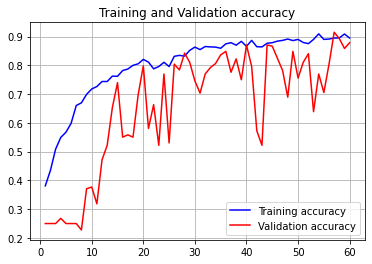

In [ ]:
# Model training metrics: "loss" and "accuracy".

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

# Train and validation accuracy.
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.grid(True)
plt.title('Training and Validation accuracy')
plt.legend();

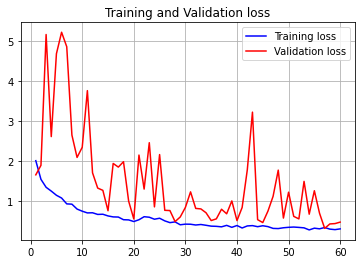

In [ ]:
# Train and validation loss.
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.grid(True)
plt.title('Training and Validation loss')
plt.legend();

# Test Image Data Generator

In [19]:
# test data generator
test_dir = os.path.join(BASE_DIR, 'test')
image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=test_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

Found 496 images belonging to 4 classes.


# Model score

In [20]:
# Model evaluation
print('[INFO] Calculating model accuracy...')

#scores = model.evaluate(X_test, Y_test)
scores = model.evaluate(test_data_gen)
model_score = round(scores[1]*100, 2)
model_score_int = int(scores[1]*100)

print('\n###########################')
print('## Test Accuracy: {:.4}% ##'.format(scores[1]*100))
print('###########################')

[INFO] Calculating model accuracy...
16/16 [==============================] - 90s 6s/step - loss: 0.2933 - accuracy: 0.9153

###########################
## Test Accuracy: 91.53% ##
###########################


# Create test data set

In [22]:
# dictionary with keys - "text label" and values - "numerical label"
label_dict = {'healthy': 0, 'multiD': 1, 'rust': 2, 'scab': 3}

In [23]:
#
def create_test_data(test_data_path=test_dir):   
    new_dataset_imgs = []
    new_dataset_labels = []
    for folder in os.listdir(test_data_path):
        folder_path = os.path.join(test_data_path, folder)
        for test_img in os.listdir(folder_path):
            test_img_path = os.path.join(folder_path, test_img)
            test_img_text_label = test_img[:-4].split("_")[1]
            
            #test_img_dummy_label = create_dummy_vector(test_img_text_label)
            
            test_img_num_label = label_dict[test_img_text_label]
            test_image = image.load_img(test_img_path, target_size=(150, 150))
            test_image_array = tf.keras.preprocessing.image.img_to_array(test_image)
            test_image_array = test_image_array / 255
            
            new_dataset_imgs.append(test_image_array)
            #new_dataset_labels.append(test_img_dummy_label)
            new_dataset_labels.append(test_img_num_label)
    
    return np.array(new_dataset_imgs), np.array(new_dataset_labels)

In [24]:
# create test data as numpy arrays
X, Y = create_test_data()

In [25]:
# stratify, shuffle and concatenate test data set
X_part1, X_part2, Y_part1, Y_part2 = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle=True)
X_test = np.concatenate((X_part1, X_part2))
Y_test = np.concatenate((Y_part1, Y_part2))

# LOAD MODEL

In [18]:
# load model
MODEL_NAME = 'Plant_Pathology_best_model_1_90_acc.h5'

#model_path = os.path.join(BASE_DIR, MODEL_NAME)
model_path = '/content/drive/MyDrive/Projects/PlantPathology_CNN_Project/plant_pathology_class_model_1_accuracy_92.h5'
model = tf.keras.models.load_model(model_path)

# Confusion Matrix Display

In [26]:
# label vector with class probabilities
Y_prob = model.predict(X_test)

In [27]:
# label vector with numerical class label
Y_pred = np.argmax(Y_prob, axis=1)

In [ ]:
#confusion_matrix(Y_test, Y_pred)

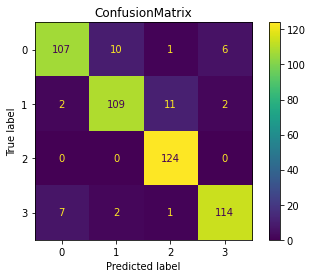

In [28]:
# display confusion matrix
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
plt.title('ConfusionMatrix')
plt.show();

# SAVE MODEL

In [29]:
# model file name
MODEL_NAME = 'plant_pathology_image_recognition_model'

model_name = MODEL_NAME + '_accuracy_' + str(model_score_int) + '_.h5'

# save the model to disk
print("[INFO] Saving model...")
path_to_save_model = os.path.join(BASE_DIR, model_name)
model.save(path_to_save_model)
print("\nModel name: ", model_name)
print("Model path: ", path_to_save_model)
print("\nModel Saved !!!")

[INFO] Saving model...

Model name:  plant_pathology_image_recognition_model_accuracy_91_.h5
Model path:  /content/drive/MyDrive/Datasets/Plant Pathology 2020 - FGVC7/images/splited_dataset/plant_pathology_image_recognition_model_accuracy_91_.h5

Model Saved !!!
